In [93]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split



data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')


class AccZDataset(Dataset):
    def __init__(self,start_no,range_len):
        data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
        self.start_no = start_no
        self.range_len = range_len
        self.data_set = data['L23MatChunk']
        self.n_trails = len(self.data_set)
        self.train_set = np.zeros((1,50000))
        
        for i in range (0,self.n_trails):
            curr = np.asarray(self.data_set[i][0][0][self.start_no : self.start_no+self.range_len]).reshape(1,self.range_len)
            self.train_set = np.append(self.train_set, curr, axis = 0)

        self.train_set = np.delete(self.train_set, (0), axis=0) #array of 20 * 50000
        
        labels = []
        for i in range(0, self.n_trails):
            if(i < 10):
                labels.append(0)
            else:
                labels.append(1)
        
        labels = np.asarray(labels).reshape(self.n_trails,1)
        self.train_set = np.append(self.train_set, labels, axis = 1)
        print(self.train_set.shape)
    def __len__(self):
        return len(self.train_set)

    def __getitem__(self, idx):
        
        sample = self.train_set[idx][:-1]
        label = self.train_set[idx][-1]

        return sample, label 



dataset = AccZDataset(20,50000)
real_value, real_label = dataset[0]
print(real_value)
print(real_value.shape)
print(real_label)




(20, 50001)
[-0.02861675 -0.03248595 -0.03233876 ... -4.65763891 -4.67567335
 -4.68219963]
(50000,)
0.0


In [154]:
data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
start_no = 0
range_len = 50000
data_set = data['L23MatChunk']
total_set = np.zeros((1,50000))

for i in range (0,n_trails):

    curr = np.asarray(data_set[i][0][0][start_no : start_no+range_len]).reshape(1,range_len)
    total_set = np.append(total_set, curr, axis = 0)

total_set = np.delete(total_set, (0), axis=0) 

labels = []
for i in range(0, n_trails):
    if(i < 10):
        labels.append(0)
    else:
        labels.append(1)

labels = np.asarray(labels).reshape(n_trails,1)
total_set = np.append(total_set, labels, axis = 1)
targets_numpy = total_set[:,-1]
features_numpy = total_set[:,:-1]
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)



featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)

featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor)
targetsTest = torch.from_numpy(targets_test).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

batch_size = len(featuresTrain)
num_epochs = 30

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

print(targets_train)


[0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.]


In [157]:

#Designing the model

filters = 1

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=25, stride=10),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=5),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=3),
            nn.ReLU())
        self.avgLayer = nn.AvgPool1d(10, stride = 2)
        self.fc1 = nn.Linear(161, 1)
#        self.fc2 = nn.Linear(64,1)
        self.sig = nn.Sigmoid()
        


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
#         blah = out.detach()[0][10].view(1,1,-1)
#         out = self.avgLayer(blah)
#         plt.subplot(2,1,2)
#         plt.plot(out.detach().numpy()[0][0])
#         out = out.detach()[:][3].view(1,1,-1)
        out = self.avgLayer(out) # batch_size * features * out of avg layer (161)
        out = self.fc1(out)
#         out = self.fc2(out)
        out = self.sig(out)
        print(out.shape) #batch_size * filters * 1 (linear layer output dimension is 1)
        return out

    
model = ConvNet()
learning_rate = 0.001
# opt = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [158]:
# real_value, real_label = dataset[]

# plt.subplot(2,1,1)
# plt.plot()
# real_value = torch.from_numpy(real_value)
# real_value = real_value.view(1,1,50000)
# real_value = real_value.float()

print(featuresTrain.shape)
output = model(featuresTrain.view(16,1,-1))
print(output)



# m = nn.Softmax(dim = 1)
# # you softmax over the 2nd dimension
# input = torch.randn(1,2)
# output = m(input)
# print(input)
# print(output)

# loss = nn.CrossEntropyLoss()
# input = torch.tensor([[1,3]], dtype = torch.float)
# print(input.dtype)
# print(input.shape)
# target = torch.LongTensor([0])
# print(target)
# output = loss(input, target)
# print(output)
# # # output.backward()

# torch.max(2,1)






torch.Size([16, 50000])
torch.Size([16, 1, 1])
tensor([[[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]]], grad_fn=<SigmoidBackward>)


torch.Size([16, 1, 1])
tensor([[[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]],

        [[0.5083]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5083]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]]], grad_fn=<SigmoidBackward>)
torch.Size([16, 1, 1])
tensor([[[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082]],

        [[0.5082

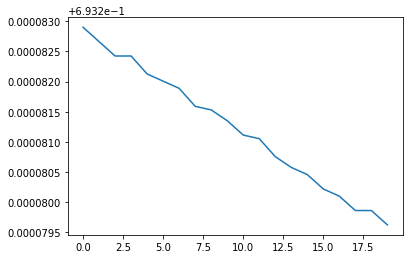

In [159]:
#  training model 
num_epochs = 20
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(train_loader):

        train = Variable(samples.view(batch_size,1,-1))
        labels = Variable(labels.view(batch_size,-1))
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        print(outputs)
        
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
#         if count % 4 == 0:
#             # Calculate Accuracy         
#             correct = 0
#             total = 0
#             # Predict test dataset
#             for samples, labels in test_loader:

#                 test = Variable(samples)
                
#                 # Forward propagation
#                 outputs = model(test)
                
#                 # Get predictions from the maximum value
#                 predicted = torch.max(outputs.data, 1)[1]
                
#                 # Total number of labels
#                 total += len(labels)

#                 # Total correct predictions
#                 correct += (predicted == labels).sum()
            
#             accuracy = 100 * correct / float(total)
            
        loss_list.append(loss.data)
#         iteration_list.append(count)
#         accuracy_list.append(accuracy)

#         print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))
plt.plot(loss_list)

In [155]:


# Training the model

#the model is currently trained with all trails (20 in total) in order to improve accuracy

num_epochs = 20 #number of sets of 50000 values required to train the model
losses = []
for x in range(num_epochs):
    if x % 2 == 0:
        value = np.random.randint(0,8)
    else:
        value = np.random.randint(11,18) #Trail number is generated here using random function
    print(value)
    real_value, real_label = trainSet(value)

    real_value = torch.from_numpy(real_value)
    real_value = real_value.view(1,1,50000)
    real_value = Variable(real_value.float())
    if value < 10:
        real_label1 = Variable(torch.LongTensor([1])) #target label is decided based on the trail number chosen by random function
    else:
        real_label1 = Variable(torch.LongTensor([0]))
    
    opt.zero_grad()
    
    output = model(real_value)
    
    loss = criterion(output, real_label1)
    
    loss.backward()
    
    opt.step()
    if(loss < 1.0 and x % 20 == 0):
        losses.append(loss.data.numpy()) 
    
plt.plot(losses)

4


NameError: name 'trainSet' is not defined

17000
(50000,)
torch.Size([1, 2])
torch.float32
tensor([[0.1393, 0.0007]])
tensor([0])
tensor(0.6263)


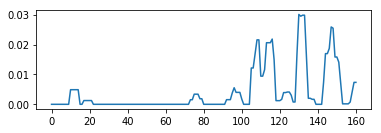

In [43]:
#Testing the model
model.eval()
real_value, real_label = trainSet(1)
real_value = torch.from_numpy(real_value)
real_value = real_value.view(1,1,50000)
real_value = Variable(real_value.float())
real_label = Variable(torch.LongTensor([0]))

with torch.no_grad():
    output = model(real_value)
print(output)
print(real_label)
loss = criterion(output, real_label)

# trial_no_2_test = np.random.randint(18,20)
# trial_no_1_test = np.random.randint(8,10)


# trial_no_test = np.random.randint(trial_no_1_test, trial_no_2_test)
# print(trial_no_test)

# real_value, real_label = trainSet(trial_no_test)

# real_value = torch.from_numpy(real_value)
# real_value = real_value.view(1,1,50000)
# real_value = real_value.float()

# output = model(real_value)
# nn.softmax(output)

# print(output)
print(loss)


In [11]:

trial_no_2 = random.randrange(11,18,1)
trial_no_1 = random.randrange(0,8,1)
print(trial_no_1)
print(trial_no_2)

trial_no_train = random.randint(trial_no_1, trial_no_2)
print(trial_no_train)

4
14
6
